In [8]:
""" 
alpha : 

price_mom = close/ts_delay(close, 2) - 1;
vol_mom = volume/ts_delay(volume, 1) - 1;
divergence = price_mom - vol_mom;
fast_sig = ts_mean(divergence,2);
slow_sig = ts_mean(divergence, 10);
combine_sig = 0.8 * fast_sig + 0.2 * slow_sig;

""" 

' \nalpha : \n\nprice_mom = close/ts_delay(close, 2) - 1;\nvol_mom = volume/ts_delay(volume, 1) - 1;\ndivergence = price_mom - vol_mom;\nfast_sig = ts_mean(divergence,2);\nslow_sig = ts_mean(divergence, 10);\ncombine_sig = 0.8 * fast_sig + 0.2 * slow_sig;\n\n'

In [2]:
# Cell 1: 導入庫並加載數據
import pandas as pd
import os
from pathlib import Path
from typing import Union, List

def load_crypto_data(
    base_path: Union[str, Path],
    symbol: str = "BTCUSDT",
    year: str = "2024",
    freq: str = "1m"
) -> pd.DataFrame:
    """
    加載並合併特定交易對的所有每日CSV文件
    
    Args:
        base_path (str/Path): 數據文件的基礎路徑
        symbol (str): 交易對名稱，如 "BTCUSDT"
        year (str): 年份，如 "2022"
        freq (str): 頻率，如 "1m"
    
    Returns:
        pd.DataFrame: 合併後的DataFrame
    """
    # 確保base_path是Path對象
    base_path = Path(base_path)
    
    # 構建文件匹配模式
    pattern = f"{symbol}_{year}-*_{freq}.csv"
    
    # 獲取所有匹配的文件並排序
    csv_files = sorted(list(base_path.glob(pattern)))
    
    if not csv_files:
        raise ValueError(f"No files found matching pattern: {pattern}")
    
    # 讀取並合併所有CSV文件
    dfs = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")
    
    # 合併所有DataFrame
    if not dfs:
        raise ValueError("No data was successfully loaded")
    
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # 確保時間列正確格式化
    merged_df['open_time'] = pd.to_datetime(merged_df['open_time'])
    merged_df['close_time'] = pd.to_datetime(merged_df['close_time'])
    
    # 按時間排序
    merged_df = merged_df.sort_values('open_time').reset_index(drop=True)
    
    # 檢查並移除重複數據
    merged_df = merged_df.drop_duplicates(subset=['open_time'], keep='first')
    
    return merged_df

def check_data_quality(df: pd.DataFrame) -> dict:
    """
    檢查合併後數據的質量
    
    Args:
        df (pd.DataFrame): 待檢查的DataFrame
    
    Returns:
        dict: 包含各種數據質量指標的字典
    """
    quality_report = {
        'total_rows': len(df),
        'date_range': (df['open_time'].min(), df['open_time'].max()),
        'missing_values': df.isnull().sum().to_dict(),
        'duplicate_times': len(df) - len(df['open_time'].unique()),
    }
    
    # 檢查時間間隔
    time_diffs = df['open_time'].diff().value_counts()
    quality_report['time_intervals'] = time_diffs
    
    return quality_report

# 假設數據路徑 (根據實際情況修改)
data_path = "/Users/mouyasushi/Desktop/quantDevops/Backtest_Performance/Alpha-Research/kline/binance/BTCUSDT/1m"

# 加載數據
btc_data = load_crypto_data(
    base_path=data_path,
    symbol="BTCUSDT",
    year="2024",
    freq="1m"
)

# 檢查數據質量
quality_report = check_data_quality(btc_data)

# 輸出基本信息
print(f"Loaded data shape: {btc_data.shape}")
print(f"Date range: {quality_report['date_range']}")
print(f"Total rows: {quality_report['total_rows']}")



Loaded data shape: (488160, 12)
Date range: (Timestamp('2024-01-01 00:00:00'), Timestamp('2024-12-04 23:59:00'))
Total rows: 488160


In [3]:
# 設置索引
btc_data = btc_data.set_index('open_time')



In [4]:
btc_data

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
open_time,,,,,,,,,,,
2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641,2024-01-01 00:00:59.999,1.225616e+07,3310,175.211,7.414460e+06,0
2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444,2024-01-01 00:01:59.999,8.572241e+06,1885,154.353,6.535805e+06,0
2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521,2024-01-01 00:02:59.999,1.150139e+07,2143,193.034,8.176843e+06,0
2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238,2024-01-01 00:03:59.999,1.662644e+07,3551,332.749,1.410472e+07,0
2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366,2024-01-01 00:04:59.999,2.411261e+07,4479,419.524,1.779786e+07,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-04 23:55:00,98803.5,98835.0,98775.7,98786.1,70.970,2024-12-04 23:55:59.999,7.012476e+06,1567,35.110,3.469313e+06,0
2024-12-04 23:56:00,98786.1,98792.9,98734.6,98770.7,151.892,2024-12-04 23:56:59.999,1.499998e+07,2414,51.604,5.096036e+06,0
2024-12-04 23:57:00,98770.7,98778.0,98740.1,98769.9,73.575,2024-12-04 23:57:59.999,7.265887e+06,1396,19.852,1.960477e+06,0


alpha 

In [10]:
# Cell 2: Alpha description
"""
Alpha formula:

price_mom = close/ts_delay(close, 2) - 1;
vol_mom = volume/ts_delay(volume, 1) - 1;
divergence = price_mom - vol_mom;
fast_sig = ts_mean(divergence, 2);
slow_sig = ts_mean(divergence, 10);
combine_sig = 0.8 * fast_sig + 0.2 * slow_sig;

This alpha strategy focuses on the divergence between price momentum and volume momentum:

1. Price momentum: Calculates 2-period price change rate
2. Volume momentum: Calculates 1-period volume change rate
3. Divergence: Subtracts volume momentum from price momentum
4. Signal generation: Creates weighted combination of fast (2-period) and slow (10-period) moving averages

The intuition is that when price increases without corresponding volume increase, 
it may indicate weaker momentum. Conversely, price increases with strong volume support
may indicate stronger trends. This alpha aims to capture these divergences to identify 
potential trading opportunities.
"""

# Cell 3: Import analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def ts_delay(series, periods):
    """
    Time series delay (lag) over a period
    """
    return series.shift(periods)

def ts_mean(series, window):
    """
    Time series mean over a rolling window
    """
    return series.rolling(window=window).mean()

def calculate_alpha(df):
    """
    Calculate alpha: 
    price_mom = close/ts_delay(close, 2) - 1;
    vol_mom = volume/ts_delay(volume, 1) - 1;
    divergence = price_mom - vol_mom;
    fast_sig = ts_mean(divergence, 2);
    slow_sig = ts_mean(divergence, 10);
    combine_sig = 0.8 * fast_sig + 0.2 * slow_sig;
    """
    df = df.copy()
    
    # Shift data to avoid look-ahead bias
    close_lag = df['close'].shift(1)
    volume_lag = df['volume'].shift(1)
    
    # Calculate price momentum (2-period)
    price_mom = close_lag / ts_delay(close_lag, 2) - 1
    
    # Calculate volume momentum (1-period)
    vol_mom = volume_lag / ts_delay(volume_lag, 1) - 1
    
    # Handle division by zero or negative values
    price_mom = price_mom.replace([np.inf, -np.inf], np.nan).fillna(0)
    vol_mom = vol_mom.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Calculate divergence between price and volume momentum
    divergence = price_mom - vol_mom
    
    # Calculate fast and slow signals
    fast_sig = ts_mean(divergence, 2)
    slow_sig = ts_mean(divergence, 10)
    
    # Combine signals with weights
    combine_sig = 0.8 * fast_sig + 0.2 * slow_sig
    
    return combine_sig

def calculate_forward_returns(df, periods=[1, 5, 10]):
    """
    Calculate forward returns for multiple periods
    """
    returns = {}
    for period in periods:
        returns[f'forward_return_{period}'] = (
            df['close'].shift(-period) / df['close'] - 1
        )
    return pd.DataFrame(returns, index=df.index)

def calculate_rolling_ic(signals, returns, window=252):
    """
    Calculate rolling Information Coefficient
    """
    rolling_ic = pd.Series(index=signals.index, dtype=float)
    
    for i in range(window, len(signals)):
        if i % 1000 == 0:  # Progress indicator
            print(f"Processing IC calculation: {i}/{len(signals)}", end='\r')
            
        s_window = signals.iloc[i-window:i]
        r_window = returns.iloc[i-window:i]
        valid_data = ~(s_window.isna() | r_window.isna())
        if valid_data.sum() > 0:
            rolling_ic.iloc[i] = stats.spearmanr(
                s_window[valid_data], 
                r_window[valid_data]
            )[0]
            
    return rolling_ic



Starting Price-Volume Divergence Alpha analysis...
Loading data...

Starting Price-Volume Divergence alpha analysis with look-ahead bias prevention...
Data range: 2024-01-01 00:00:00 to 2024-12-04 23:59:00
Total rows: 488160
Calculating alpha...
Calculating forward returns...
Running period analysis...

Analyzing period 1...
Calculating rolling IC for period 1...
Processing IC calculation: 488000/488140
Analyzing period 5...
Calculating rolling IC for period 5...
Processing IC calculation: 488000/488140
Analyzing period 10...
Calculating rolling IC for period 10...
Processing IC calculation: 488000/488140
Period 1 Analysis (Using Past Data Only):
--------------------------------------------------
Information Coefficient (IC): -0.0007
IC-IR: -0.0153
Turnover: 1.0343
Q5-Q1 Spread: -0.4714 (1e-5)
T-Statistic: nan

Quintile Returns (1e-5):
alpha_lag
Q1    0.404233
Q2    0.206732
Q3    0.294648
Q4    0.173092
Q5   -0.067147
Name: forward_return_1, dtype: float64

Period 5 Analysis (Using Pa

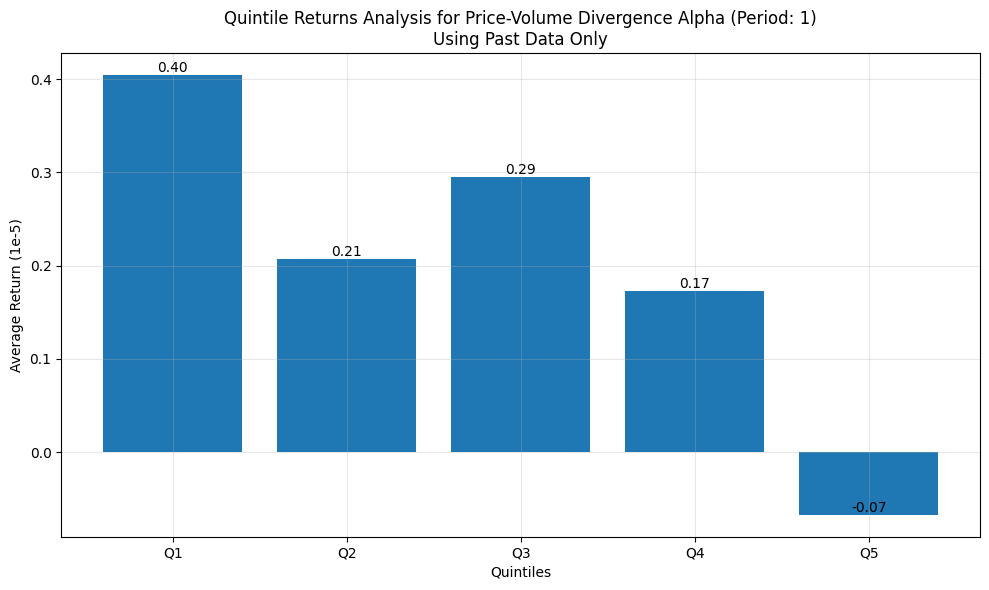

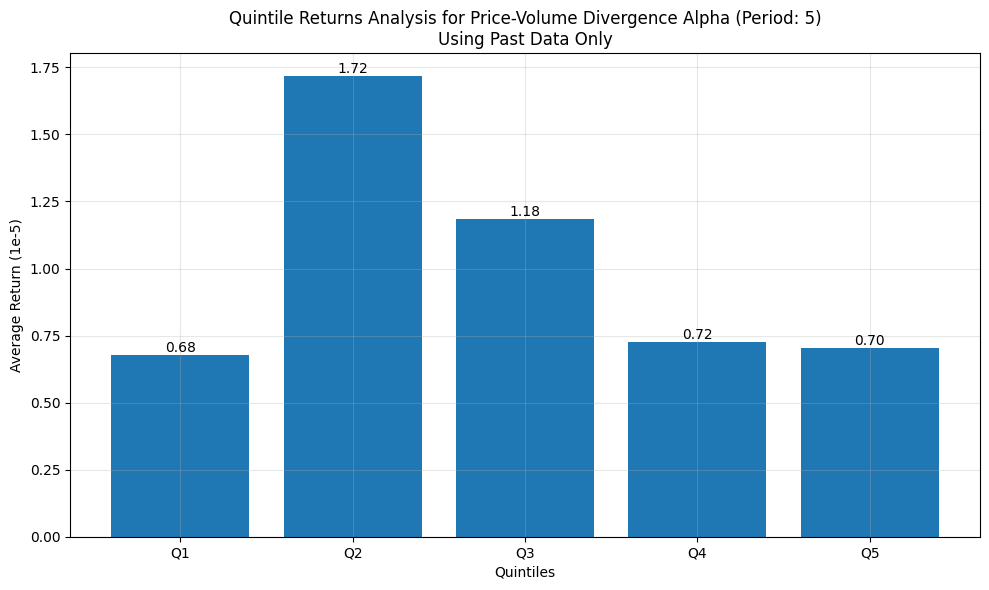

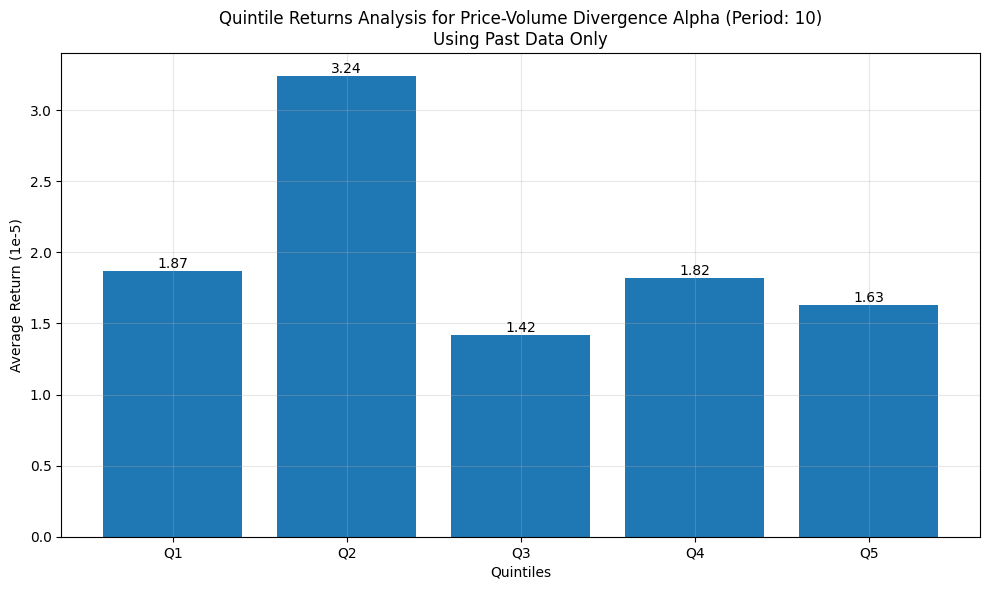

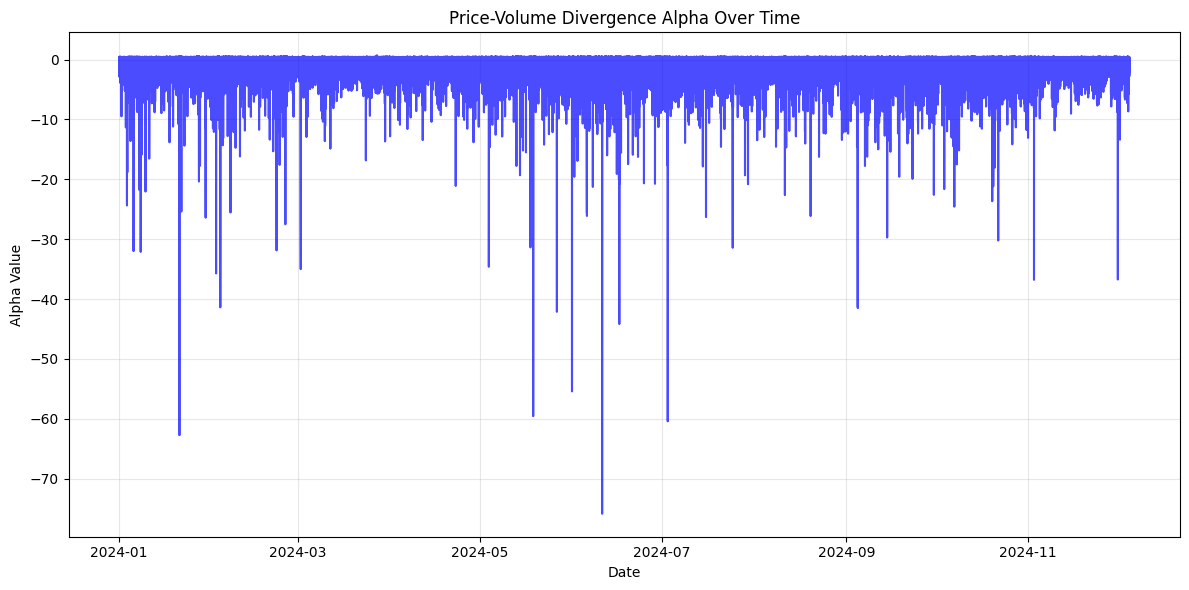

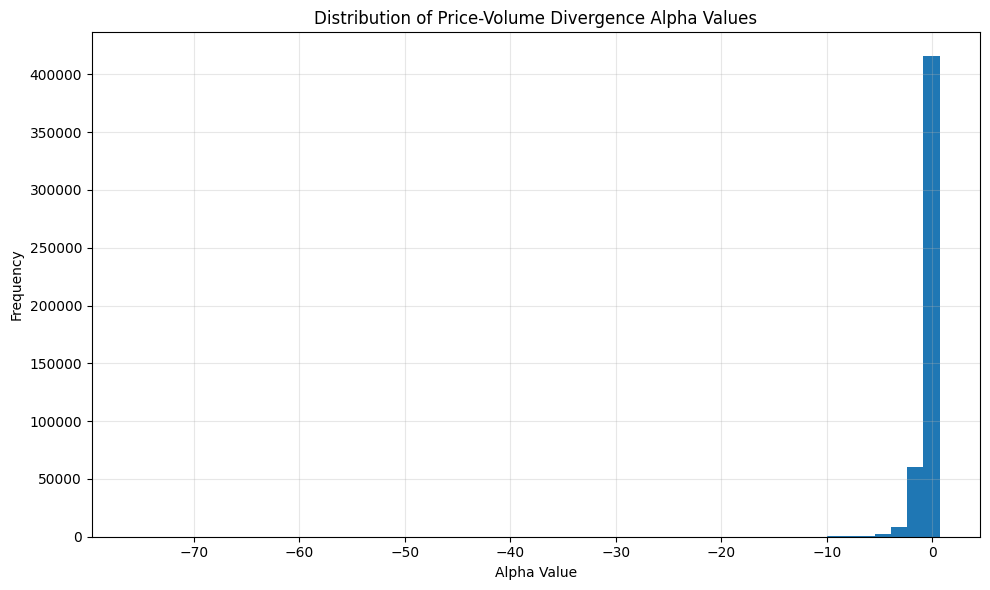

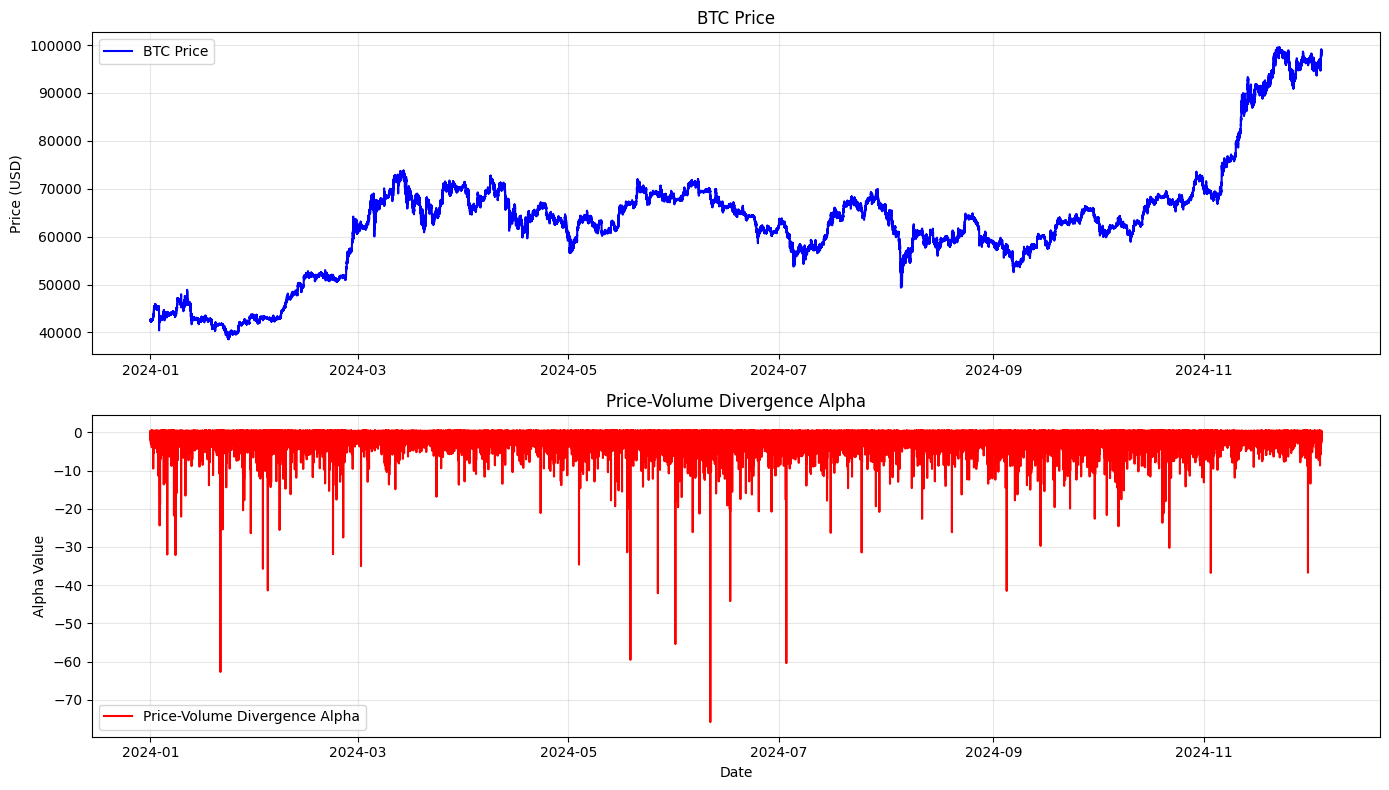

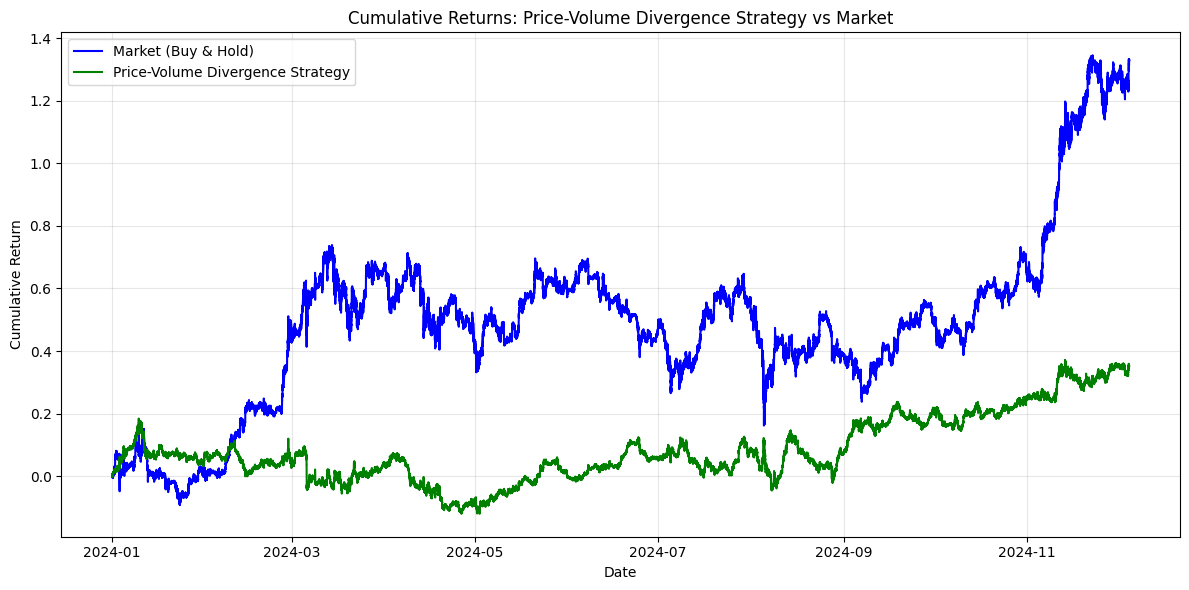

Total Return: 0.351916
Annual Return: 0.266282
Annual Volatility: 0.290273
Sharpe Ratio: 0.917350
Max Drawdown: 0.304196
Win Rate: 0.501762
Profit Factor: 1.007626


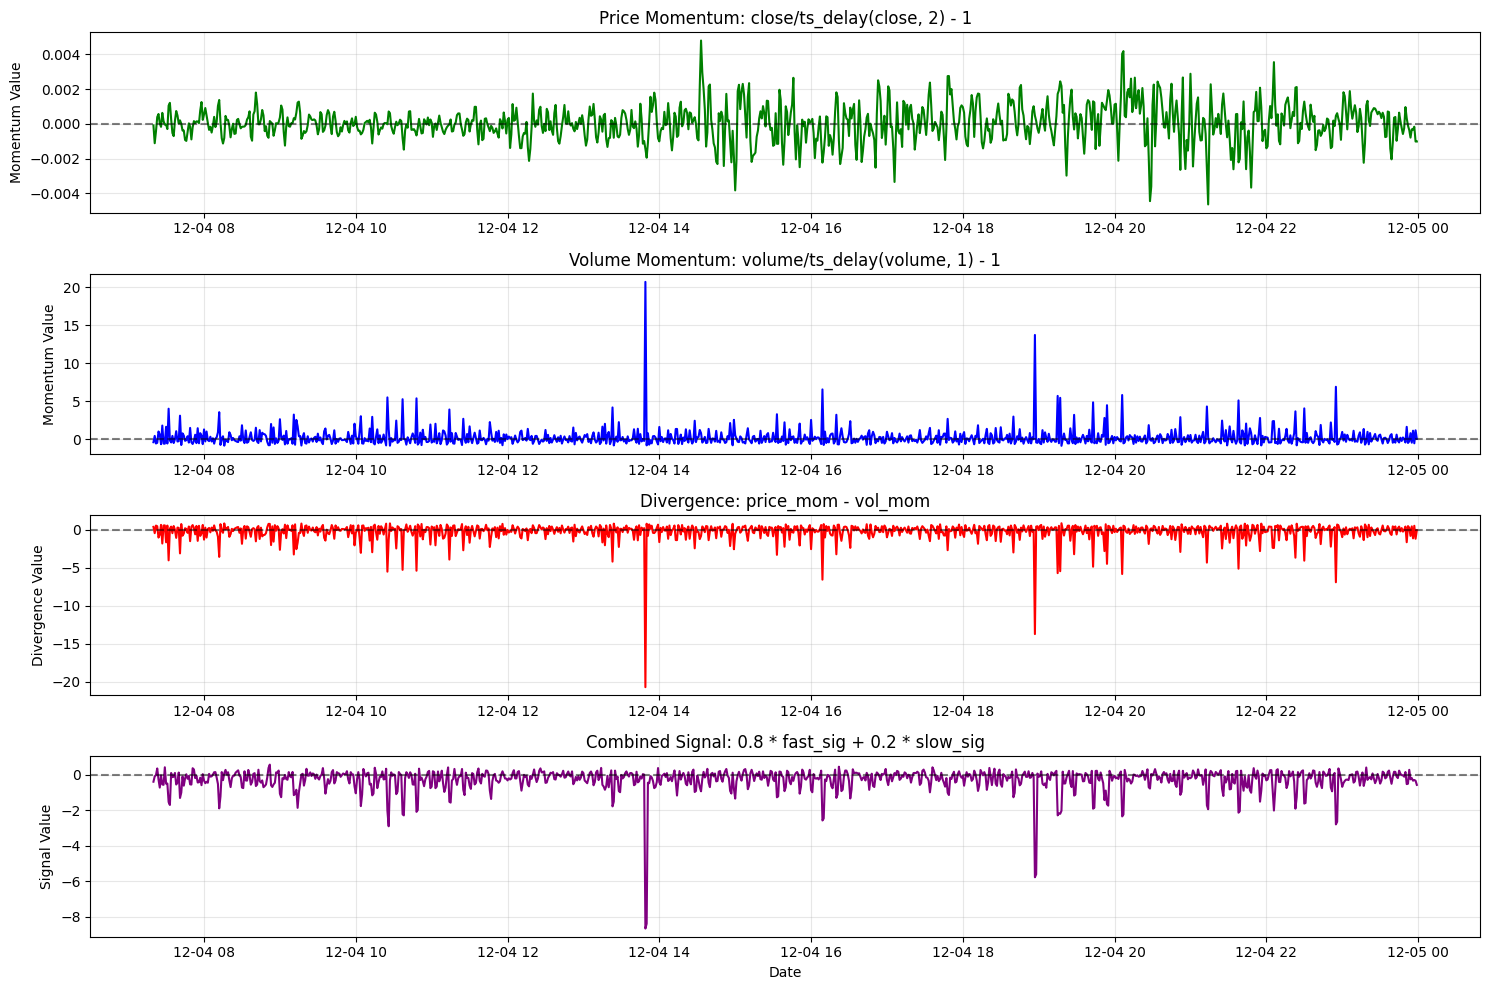

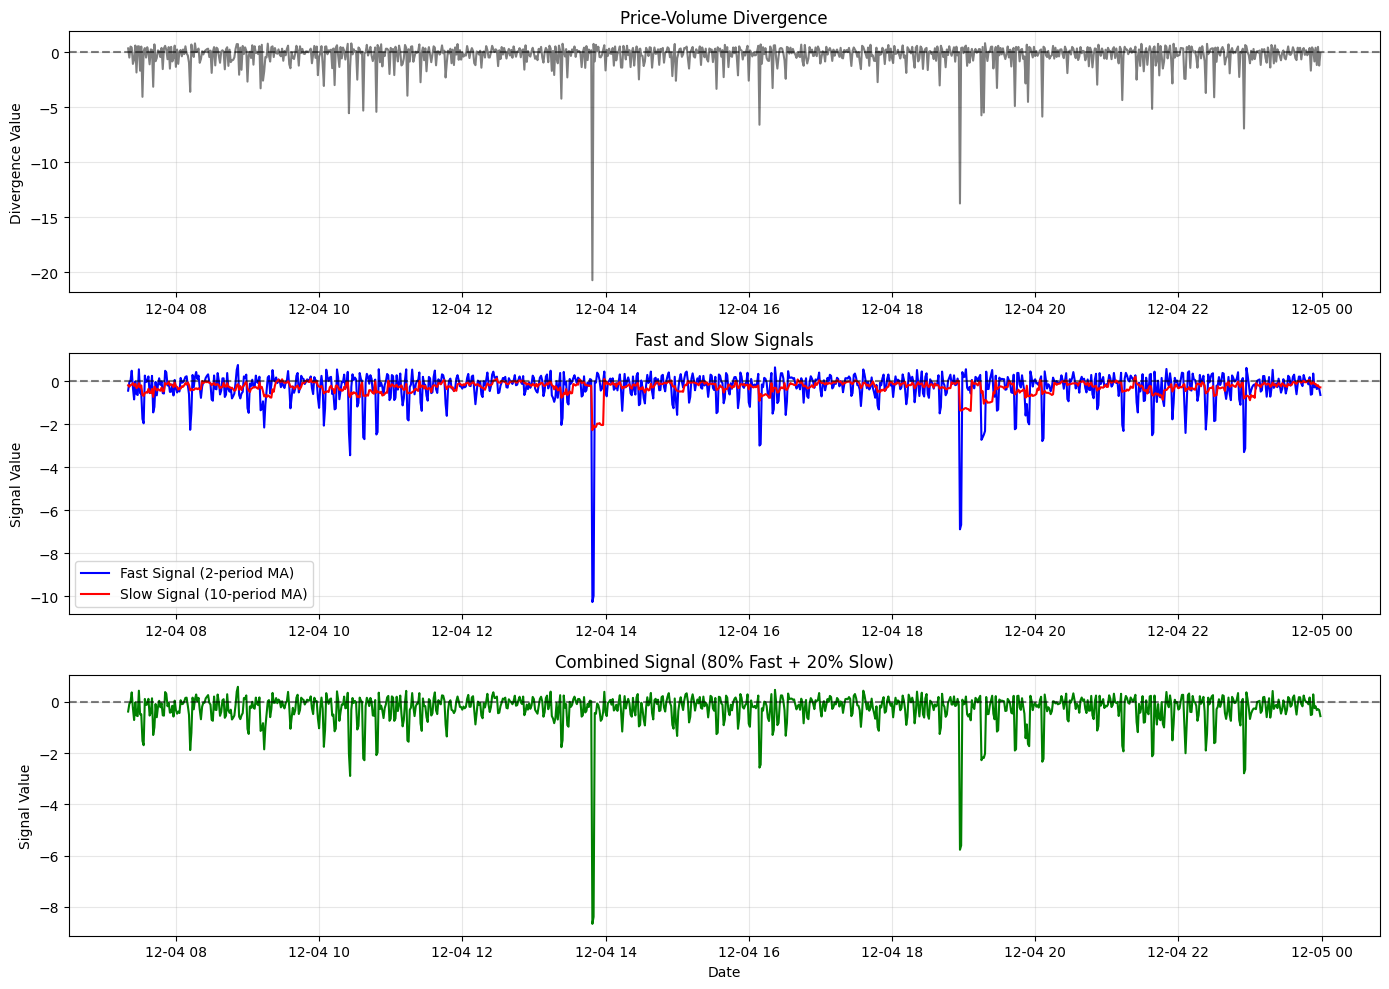

Correlation of Alpha Components with Forward Returns:
             Period 1  Period 5  Period 10
Component                                 
combine_sig       NaN       NaN        NaN
divergence        NaN       NaN        NaN
fast_sig          NaN       NaN        NaN
price_mom         NaN       NaN        NaN
slow_sig          NaN       NaN        NaN
vol_mom           NaN       NaN        NaN


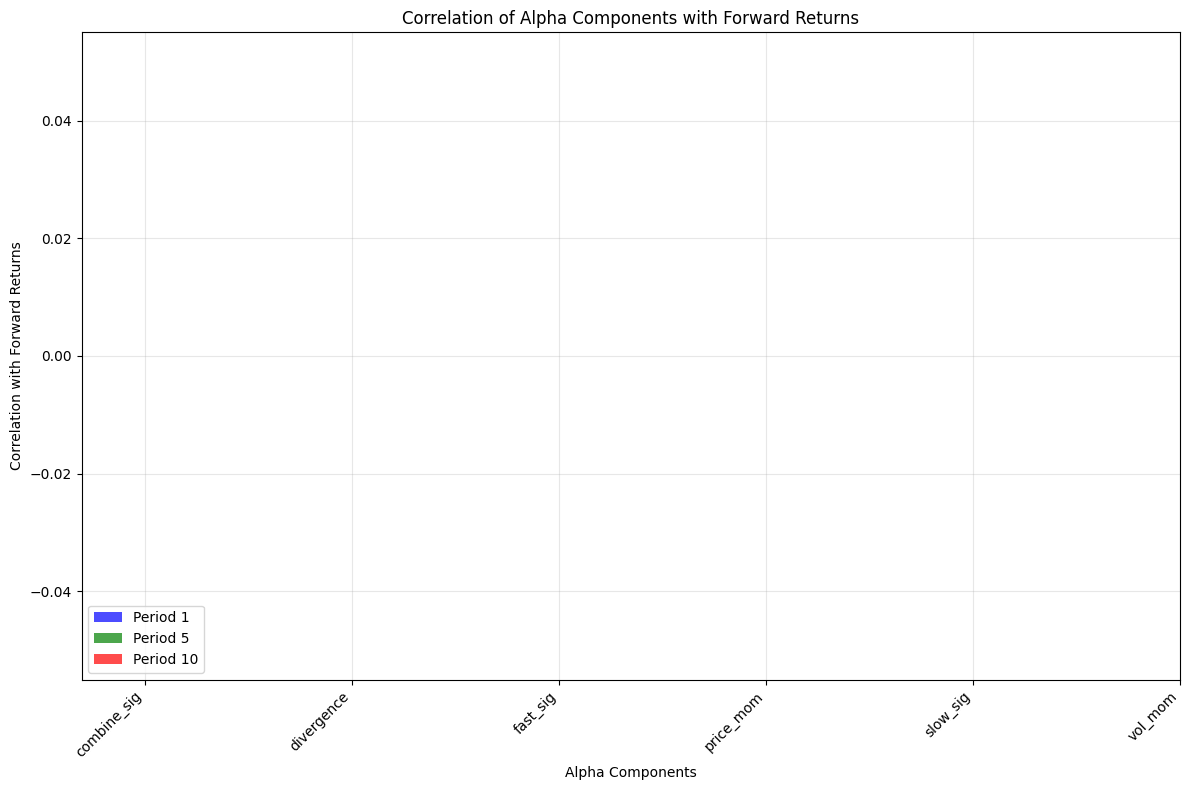


Average Alpha Value by Volume Quantile:
volume_quantile
V1   -0.124395
V2   -0.210970
V3   -0.298457
V4   -0.420221
V5   -0.781708
Name: combine_sig, dtype: float64

Alpha Correlation with Returns by Volume Quantile:
                 Period 1  Period 5  Period 10
Volume Quantile                               
V1                    NaN       NaN        NaN
V2                    NaN       NaN        NaN
V3                    NaN       NaN        NaN
V4                    NaN       NaN        NaN
V5                    NaN       NaN        NaN


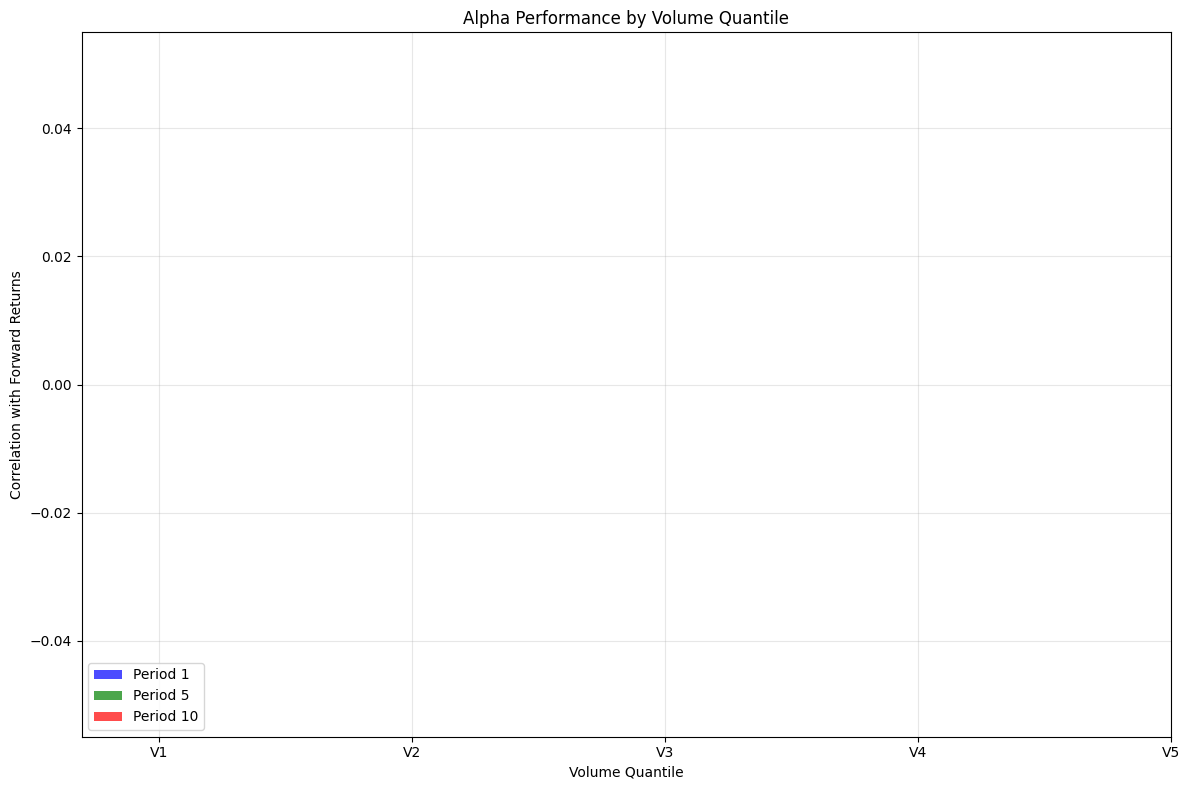


Alpha Correlation with Returns by Volatility Quantile:
                     Period 1  Period 5  Period 10
Volatility Quantile                               
Vol1                      NaN       NaN        NaN
Vol2                      NaN       NaN        NaN
Vol3                      NaN       NaN        NaN
Vol4                      NaN       NaN        NaN
Vol5                      NaN       NaN        NaN


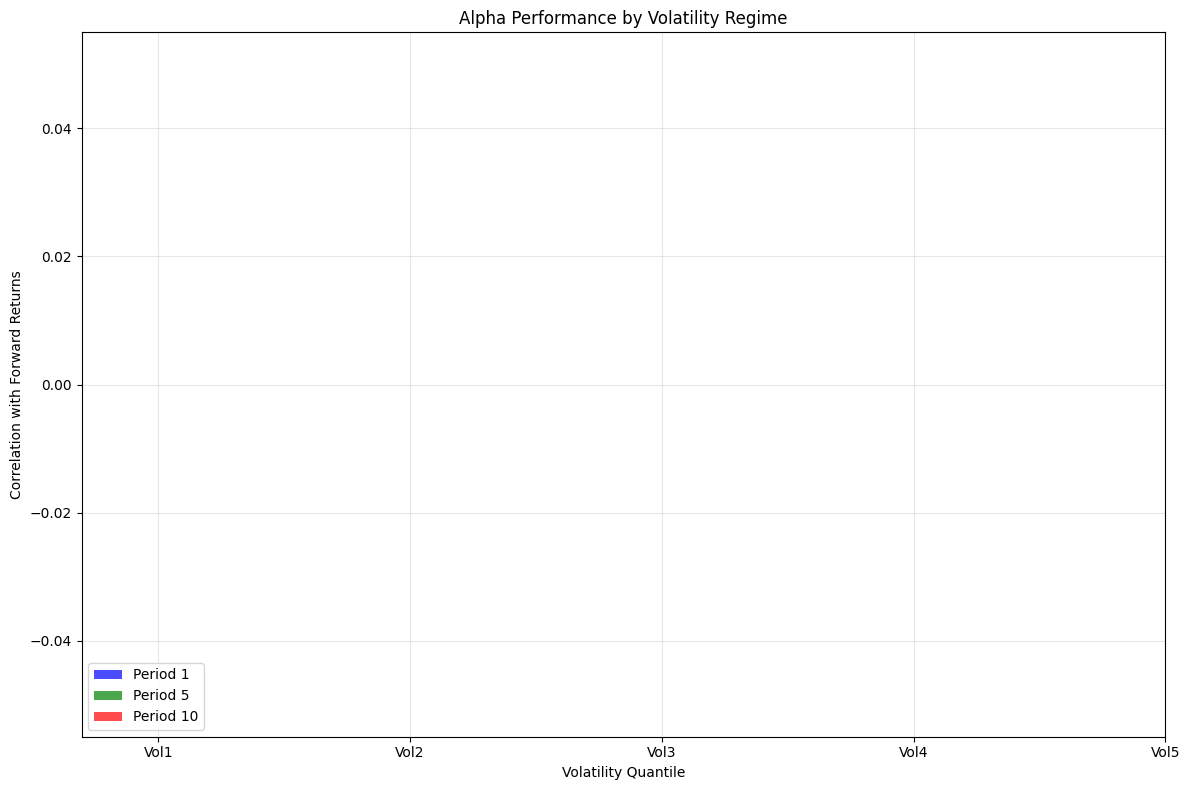

In [11]:
def analyze_alpha(df, alpha_name='alpha', periods=[1, 5, 10]):
    """
    Comprehensive alpha analysis with look-ahead bias prevention
    """
    df = df.copy()
    results = {}
    
    # Calculate alpha first (using only past data)
    print("Calculating alpha...")
    df['alpha'] = calculate_alpha(df)
    
    # Calculate forward returns (our targets)
    print("Calculating forward returns...")
    forward_returns = calculate_forward_returns(df, periods)
    df = pd.concat([df, forward_returns], axis=1)
    
    # Shift alpha to ensure we're using past signal for future returns
    df['alpha_lag'] = df['alpha'].shift(1)
    
    # Remove NaN values
    df = df.dropna()
    
    print("Running period analysis...")
    for period in periods:
        print(f"\nAnalyzing period {period}...")
        return_col = f'forward_return_{period}'
        period_results = {}
        
        # Calculate IC using lagged alpha
        ic = stats.spearmanr(df['alpha_lag'], df[return_col])[0]
        period_results['IC'] = ic
        
        # Calculate rolling IC
        print(f"Calculating rolling IC for period {period}...")
        rolling_ic = calculate_rolling_ic(df['alpha_lag'], df[return_col])
        valid_ic = rolling_ic.dropna()
        if len(valid_ic) > 0:
            icir = valid_ic.mean() / valid_ic.std()
            period_results['ICIR'] = icir
        else:
            period_results['ICIR'] = np.nan
        
        # Calculate turnover
        period_results['turnover'] = (
            df['alpha_lag'].diff().abs().mean() / df['alpha_lag'].abs().mean()
        )
        
        # Calculate quintile returns
        try:
            quintiles = pd.qcut(df['alpha_lag'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
            quintile_returns = df.groupby(quintiles)[return_col].mean()
            period_results['quintile_returns'] = quintile_returns
            
            # Calculate spread (Q5-Q1)
            period_results['spread'] = quintile_returns['Q5'] - quintile_returns['Q1']
            
            # Calculate t-stat of spread
            spread_series = df[df['alpha_lag'] >= df['alpha_lag'].quantile(0.8)][return_col] - \
                          df[df['alpha_lag'] <= df['alpha_lag'].quantile(0.2)][return_col]
            t_stat = np.sqrt(len(spread_series)) * spread_series.mean() / spread_series.std()
            period_results['t_stat'] = t_stat
            
        except Exception as e:
            print(f"Error in quintile calculation for period {period}: {e}")
            continue
            
        results[period] = period_results
    
    return results, df

def plot_quintile_analysis(results, period):
    """
    Plot quintile analysis
    """
    plt.figure(figsize=(10, 6))
    quintile_returns = results[period]['quintile_returns']
    
    bars = plt.bar(range(len(quintile_returns)), quintile_returns * 1e5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    plt.title(f'Quintile Returns Analysis for Price-Volume Divergence Alpha (Period: {period})\nUsing Past Data Only')
    plt.xlabel('Quintiles')
    plt.ylabel('Average Return (1e-5)')
    plt.xticks(range(len(quintile_returns)), quintile_returns.index)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt

def print_analysis_results(results):
    """
    Print comprehensive analysis results
    """
    for period, period_results in results.items():
        print(f"\nPeriod {period} Analysis (Using Past Data Only):")
        print("-" * 50)
        print(f"Information Coefficient (IC): {period_results['IC']:.4f}")
        print(f"IC-IR: {period_results['ICIR']:.4f}")
        print(f"Turnover: {period_results['turnover']:.4f}")
        print(f"Q5-Q1 Spread: {period_results['spread']*1e5:.4f} (1e-5)")
        print(f"T-Statistic: {period_results['t_stat']:.4f}")
        print("\nQuintile Returns (1e-5):")
        print(period_results['quintile_returns'] * 1e5)

def run_alpha_analysis(df, periods=[1, 5, 10]):
    """
    Run complete alpha analysis
    """
    print("\nStarting Price-Volume Divergence alpha analysis with look-ahead bias prevention...")
    print("Data range:", df.index.min(), "to", df.index.max())
    print("Total rows:", len(df))
    
    results, df_with_alpha = analyze_alpha(df, periods=periods)
    print_analysis_results(results)
    
    for period in periods:
        plot_quintile_analysis(results, period)
        plt.show()
    
    return results, df_with_alpha

# Cell 4: Run the analysis
# Assign the DataFrame for analysis
df = btc_data

# Define a main function to execute the analysis
def main(df):
    """
    Main execution function
    """
    print("Loading data...")
    periods = [1, 5, 10]
    results, df_with_alpha = run_alpha_analysis(df, periods=periods)
    
    # Additional analysis: plot alpha value over time
    plt.figure(figsize=(12, 6))
    plt.plot(df_with_alpha.index, df_with_alpha['alpha'], 'b-', alpha=0.7)
    plt.title('Price-Volume Divergence Alpha Over Time')
    plt.xlabel('Date')
    plt.ylabel('Alpha Value')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot alpha distribution
    plt.figure(figsize=(10, 6))
    df_with_alpha['alpha'].hist(bins=50)
    plt.title('Distribution of Price-Volume Divergence Alpha Values')
    plt.xlabel('Alpha Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results, df_with_alpha

# Execute the main function
print("Starting Price-Volume Divergence Alpha analysis...")
results, df_with_alpha = main(df)

# Cell 5: Additional Analysis - Compare alpha with price
# Plot alpha vs price
plt.figure(figsize=(14, 8))

# Create two subplots
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)

# Plot BTC price on the first subplot
ax1.plot(df_with_alpha.index, df_with_alpha['close'], 'b-', label='BTC Price')
ax1.set_ylabel('Price (USD)')
ax1.set_title('BTC Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot alpha value on the second subplot
ax2.plot(df_with_alpha.index, df_with_alpha['alpha'], 'r-', label='Price-Volume Divergence Alpha')
ax2.set_ylabel('Alpha Value')
ax2.set_xlabel('Date')
ax2.set_title('Price-Volume Divergence Alpha')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 6: Analyze trading signals
# Create trading signals from alpha
df_with_alpha['signal'] = 0
df_with_alpha.loc[df_with_alpha['alpha_lag'] > df_with_alpha['alpha_lag'].quantile(0.8), 'signal'] = 1  # Buy signals
df_with_alpha.loc[df_with_alpha['alpha_lag'] < df_with_alpha['alpha_lag'].quantile(0.2), 'signal'] = -1  # Sell signals

# Calculate strategy returns (assuming we trade on the signal at next minute's close)
df_with_alpha['strategy_return'] = df_with_alpha['signal'].shift(1) * df_with_alpha['forward_return_1']

# Calculate cumulative returns
df_with_alpha['cum_market_return'] = (1 + df_with_alpha['forward_return_1']).cumprod() - 1
df_with_alpha['cum_strategy_return'] = (1 + df_with_alpha['strategy_return']).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df_with_alpha.index, df_with_alpha['cum_market_return'], 'b-', label='Market (Buy & Hold)')
plt.plot(df_with_alpha.index, df_with_alpha['cum_strategy_return'], 'g-', label='Price-Volume Divergence Strategy')
plt.title('Cumulative Returns: Price-Volume Divergence Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cell 7: Calculate strategy performance metrics
# Performance metrics
performance = {
    'Total Return': df_with_alpha['cum_strategy_return'].iloc[-1],
    'Annual Return': df_with_alpha['strategy_return'].mean() * 252 * 24 * 60,  # For 1-min data
    'Annual Volatility': df_with_alpha['strategy_return'].std() * np.sqrt(252 * 24 * 60),  # For 1-min data
    'Sharpe Ratio': (df_with_alpha['strategy_return'].mean() / df_with_alpha['strategy_return'].std()) * np.sqrt(252 * 24 * 60),  # For 1-min data
    'Max Drawdown': (df_with_alpha['cum_strategy_return'].cummax() - df_with_alpha['cum_strategy_return']).max(),
    'Win Rate': len(df_with_alpha[df_with_alpha['strategy_return'] > 0]) / len(df_with_alpha[df_with_alpha['strategy_return'] != 0]),
    'Profit Factor': df_with_alpha[df_with_alpha['strategy_return'] > 0]['strategy_return'].sum() / abs(df_with_alpha[df_with_alpha['strategy_return'] < 0]['strategy_return'].sum())
}

for metric, value in performance.items():
    print(f"{metric}: {value:.6f}")

# Cell 8: Visualize the price and volume momentum components
# Calculate the components for visualization
df_viz = df.copy()
df_viz['price_mom'] = df_viz['close'] / df_viz['close'].shift(2) - 1
df_viz['vol_mom'] = df_viz['volume'] / df_viz['volume'].shift(1) - 1
df_viz['divergence'] = df_viz['price_mom'] - df_viz['vol_mom']
df_viz['fast_sig'] = ts_mean(df_viz['divergence'], 2)
df_viz['slow_sig'] = ts_mean(df_viz['divergence'], 10)
df_viz['combine_sig'] = 0.8 * df_viz['fast_sig'] + 0.2 * df_viz['slow_sig']

# Plot the components
plt.figure(figsize=(15, 10))

# Plot price momentum
plt.subplot(4, 1, 1)
plt.plot(df_viz.index[-1000:], df_viz['price_mom'][-1000:], 'g-')
plt.title('Price Momentum: close/ts_delay(close, 2) - 1')
plt.ylabel('Momentum Value')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Plot volume momentum
plt.subplot(4, 1, 2)
plt.plot(df_viz.index[-1000:], df_viz['vol_mom'][-1000:], 'b-')
plt.title('Volume Momentum: volume/ts_delay(volume, 1) - 1')
plt.ylabel('Momentum Value')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Plot divergence
plt.subplot(4, 1, 3)
plt.plot(df_viz.index[-1000:], df_viz['divergence'][-1000:], 'r-')
plt.title('Divergence: price_mom - vol_mom')
plt.ylabel('Divergence Value')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Plot combined signal
plt.subplot(4, 1, 4)
plt.plot(df_viz.index[-1000:], df_viz['combine_sig'][-1000:], 'purple')
plt.title('Combined Signal: 0.8 * fast_sig + 0.2 * slow_sig')
plt.ylabel('Signal Value')
plt.xlabel('Date')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 9: Visualize the fast and slow signal components
plt.figure(figsize=(14, 10))

# Plot divergence
plt.subplot(3, 1, 1)
plt.plot(df_viz.index[-1000:], df_viz['divergence'][-1000:], 'k-', alpha=0.5)
plt.title('Price-Volume Divergence')
plt.ylabel('Divergence Value')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Plot fast and slow signals
plt.subplot(3, 1, 2)
plt.plot(df_viz.index[-1000:], df_viz['fast_sig'][-1000:], 'b-', label='Fast Signal (2-period MA)')
plt.plot(df_viz.index[-1000:], df_viz['slow_sig'][-1000:], 'r-', label='Slow Signal (10-period MA)')
plt.title('Fast and Slow Signals')
plt.ylabel('Signal Value')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot combined signal
plt.subplot(3, 1, 3)
plt.plot(df_viz.index[-1000:], df_viz['combine_sig'][-1000:], 'g-')
plt.title('Combined Signal (80% Fast + 20% Slow)')
plt.ylabel('Signal Value')
plt.xlabel('Date')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 10: Analyze the correlation between signal components and returns
# Calculate correlations for different components
# We'll see which part contributes more to the predictive power

# Calculate forward returns if not already available
if 'forward_return_1' not in df_viz.columns:
    df_viz['forward_return_1'] = df_viz['close'].shift(-1) / df_viz['close'] - 1
    df_viz['forward_return_5'] = df_viz['close'].shift(-5) / df_viz['close'] - 1
    df_viz['forward_return_10'] = df_viz['close'].shift(-10) / df_viz['close'] - 1

# Calculate correlations
correlation_data = []

# Calculate for each component
for component in ['price_mom', 'vol_mom', 'divergence', 'fast_sig', 'slow_sig', 'combine_sig']:
    for period in [1, 5, 10]:
        ret_col = f'forward_return_{period}'
        corr = stats.spearmanr(df_viz[component].shift(1), df_viz[ret_col])[0]
        correlation_data.append({
            'Component': component,
            'Period': period,
            'Correlation': corr
        })

# Convert to DataFrame for easy display
corr_df = pd.DataFrame(correlation_data)
corr_df = corr_df.pivot(index='Component', columns='Period', values='Correlation')
corr_df.columns = [f'Period {p}' for p in corr_df.columns]

# Display correlation table
print("Correlation of Alpha Components with Forward Returns:")
print(corr_df)

# Create a bar chart of correlations
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red']
bar_width = 0.25
index = np.arange(len(corr_df.index))

for i, period in enumerate(corr_df.columns):
    plt.bar(index + i*bar_width, corr_df[period], bar_width, 
            label=period, color=colors[i], alpha=0.7)

plt.xlabel('Alpha Components')
plt.ylabel('Correlation with Forward Returns')
plt.title('Correlation of Alpha Components with Forward Returns')
plt.xticks(index + bar_width, corr_df.index, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# Cell 11: Analyze the relationship between signal and volume profile
# Let's examine how the alpha performs under different volume conditions

# Create volume quantiles
df_viz['volume_quantile'] = pd.qcut(df_viz['volume'], 5, labels=['V1', 'V2', 'V3', 'V4', 'V5'])

# Calculate average alpha value per volume quantile
vol_alpha_relation = df_viz.groupby('volume_quantile')['combine_sig'].mean()
print("\nAverage Alpha Value by Volume Quantile:")
print(vol_alpha_relation)

# Calculate alpha predictive power per volume quantile
alpha_performance_by_volume = []

for vol_q in ['V1', 'V2', 'V3', 'V4', 'V5']:
    vol_mask = df_viz['volume_quantile'] == vol_q
    for period in [1, 5, 10]:
        ret_col = f'forward_return_{period}'
        corr = stats.spearmanr(
            df_viz.loc[vol_mask, 'combine_sig'].shift(1), 
            df_viz.loc[vol_mask, ret_col]
        )[0]
        alpha_performance_by_volume.append({
            'Volume Quantile': vol_q,
            'Period': period,
            'Correlation': corr
        })

# Convert to DataFrame for easy display
vol_perf_df = pd.DataFrame(alpha_performance_by_volume)
vol_perf_df = vol_perf_df.pivot(index='Volume Quantile', columns='Period', values='Correlation')
vol_perf_df.columns = [f'Period {p}' for p in vol_perf_df.columns]

print("\nAlpha Correlation with Returns by Volume Quantile:")
print(vol_perf_df)

# Plot alpha performance by volume quantile
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red']
bar_width = 0.25
index = np.arange(len(vol_perf_df.index))

for i, period in enumerate(vol_perf_df.columns):
    plt.bar(index + i*bar_width, vol_perf_df[period], bar_width, 
            label=period, color=colors[i], alpha=0.7)

plt.xlabel('Volume Quantile')
plt.ylabel('Correlation with Forward Returns')
plt.title('Alpha Performance by Volume Quantile')
plt.xticks(index + bar_width, vol_perf_df.index)
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# Cell 12: Analyze the relationship between signal and market volatility
# Let's see how the alpha performs under different volatility regimes

# Calculate volatility (using 10-period rolling standard deviation of returns)
df_viz['volatility'] = df_viz['close'].pct_change().rolling(10).std()
df_viz['volatility_quantile'] = pd.qcut(df_viz['volatility'], 5, labels=['Vol1', 'Vol2', 'Vol3', 'Vol4', 'Vol5'])

# Calculate alpha predictive power per volatility quantile
alpha_performance_by_volatility = []

for vol_q in ['Vol1', 'Vol2', 'Vol3', 'Vol4', 'Vol5']:
    vol_mask = df_viz['volatility_quantile'] == vol_q
    for period in [1, 5, 10]:
        ret_col = f'forward_return_{period}'
        corr = stats.spearmanr(
            df_viz.loc[vol_mask, 'combine_sig'].shift(1), 
            df_viz.loc[vol_mask, ret_col]
        )[0]
        alpha_performance_by_volatility.append({
            'Volatility Quantile': vol_q,
            'Period': period,
            'Correlation': corr
        })

# Convert to DataFrame for easy display
vol_perf_df = pd.DataFrame(alpha_performance_by_volatility)
vol_perf_df = vol_perf_df.pivot(index='Volatility Quantile', columns='Period', values='Correlation')
vol_perf_df.columns = [f'Period {p}' for p in vol_perf_df.columns]

print("\nAlpha Correlation with Returns by Volatility Quantile:")
print(vol_perf_df)

# Plot alpha performance by volatility quantile
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red']
bar_width = 0.25
index = np.arange(len(vol_perf_df.index))

for i, period in enumerate(vol_perf_df.columns):
    plt.bar(index + i*bar_width, vol_perf_df[period], bar_width, 
            label=period, color=colors[i], alpha=0.7)

plt.xlabel('Volatility Quantile')
plt.ylabel('Correlation with Forward Returns')
plt.title('Alpha Performance by Volatility Regime')
plt.xticks(index + bar_width, vol_perf_df.index)
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()